1. Load Cifar-10

In [41]:
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.init as init

import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import flatten
import os
from torchsummary import summary

In [42]:
import pickle
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Return the total number of samples
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and label at the specified index
        image = self.images[idx]
        label = self.labels[idx]

        # Convert the image from numpy to PIL for transformations, if necessary
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
        
        # Apply any transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        # Use encoding='bytes' for Python 3 compatibility
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reorder dimensions to (num_samples, 32, 32, 3)
        return images, labels

# Load all batches
def load_cifar10_data(data_dir):
    train_images = []
    train_labels = []
    validation_images = []
    validation_labels = []

    # Loop through the training batches
    for i in range(1, 6):
        filename = os.path.join(data_dir, f"data_batch_{i}")
        images, labels = load_cifar10_batch(filename)
        if i < 5:
            train_images.append(images)
            train_labels.extend(labels)
        else:
            validation_images.append(images)
            validation_labels.append(labels)

    # Combine all training batches
    train_images = np.concatenate(train_images)
    train_labels = np.array(train_labels)
    validation_images = np.concatenate(validation_images)
    validation_labels = np.array(validation_labels).reshape(-1)
    

    # Load the test batch
    test_images, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    test_labels = np.array(test_labels)

    return (train_images, train_labels), (validation_images, validation_labels), (test_images, test_labels)

# Specify the directory where CIFAR-10 files are located
data_dir = 'cifar-10-python\cifar-10-batches-py'
(train_images, train_labels), (validation_images, validation_labels), (test_images, test_labels) = load_cifar10_data(data_dir)


print("Training data shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation data shape:", validation_images.shape)
print("Validation labels shape:", validation_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


<>:77: SyntaxWarning: invalid escape sequence '\c'
<>:77: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17440\1709088659.py:77: SyntaxWarning: invalid escape sequence '\c'
  data_dir = 'cifar-10-python\cifar-10-batches-py'


Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000,)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


In [43]:
train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
train_labels = torch.tensor(train_labels, dtype=torch.float32)
validation_images = torch.tensor(validation_images, dtype=torch.float32).permute(0, 3, 1, 2)  / 255.0
validation_labels = torch.tensor(validation_labels, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)  / 255.0
test_labels = torch.tensor(test_labels, dtype=torch.float32)

In [ ]:
batch_size = 64
train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(validation_images, validation_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=batch_size, shuffle=False)

Resnet-18 from Scratch
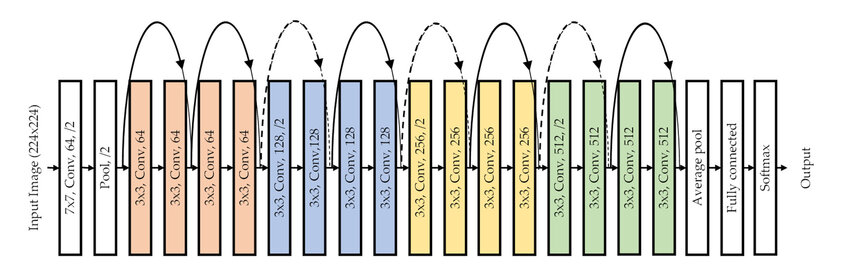

In [38]:
class BasicBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride = 1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(output_channels) 

        self.conv2 = nn.Conv2d(output_channels,output_channels,kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        
        self.shortcut = nn.Identity() 
        if stride != 1:            
            self.shortcut = nn.Sequential(
                            nn.Conv2d(input_channels, output_channels, kernel_size = 1, stride = stride, bias = False),
                            nn.BatchNorm2d(output_channels)
                            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) 
        out = F.relu(out)
        
        return out

In [39]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes = 10):
        super(ResNet, self).__init__()
        self.input_channels = 64
        
        self.conv1 = nn.Conv2d(3,64,kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, output_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.input_channels, output_channels, stride))
            self.input_channels = output_channels
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1) # out.size(0) = out.reshape(0)
        out = self.linear(out)
        
        return out

In [40]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [169]:
device = 'cuda'
cudnn.benchmark = True

model = ResNet18()
model = model.to(device)
model = torch.nn.DataParallel(model)

learning_rate = 0.01
file_name = 'resnet18_cifar10.pth'

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.0002)

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Identity()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

In [7]:

def training(epochs, model, criterion, optimizer, device, train_loader, file_name):
    losses = []
    val_losses = []
    val_acc = []
    smallest_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.long().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        losses.append(total_loss)
        val_losses.append(val_loss)
        val_acc.append(correct/total)

        val_loss /= len(val_loader)
        if val_loss < smallest_loss:
            smallest_loss = val_loss
            torch.save(model.state_dict(), file_name)
        print(f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {total_loss/len(train_loader):.4f}, "
            f"Validation Loss: {val_loss:.4f}, "
            f"Validation Accuracy: {100 * correct / total:.2f}%")
    return losses, val_losses, val_acc

In [142]:
train_loss, val_loss, val_acc = training(100, model, criterion, optimizer, device,train_loader, file_name)

Epoch [1/100], Train Loss: 1.3435, Validation Loss: 1.2383, Validation Accuracy: 58.63%
Epoch [2/100], Train Loss: 0.8214, Validation Loss: 0.8387, Validation Accuracy: 72.18%
Epoch [3/100], Train Loss: 0.6034, Validation Loss: 0.6916, Validation Accuracy: 76.31%
Epoch [4/100], Train Loss: 0.4440, Validation Loss: 0.6719, Validation Accuracy: 77.33%
Epoch [5/100], Train Loss: 0.3227, Validation Loss: 0.6557, Validation Accuracy: 79.14%
Epoch [6/100], Train Loss: 0.2309, Validation Loss: 0.7456, Validation Accuracy: 77.80%
Epoch [7/100], Train Loss: 0.1580, Validation Loss: 0.7901, Validation Accuracy: 79.53%
Epoch [8/100], Train Loss: 0.1080, Validation Loss: 1.0302, Validation Accuracy: 77.52%
Epoch [9/100], Train Loss: 0.0894, Validation Loss: 1.0534, Validation Accuracy: 75.43%
Epoch [10/100], Train Loss: 0.0705, Validation Loss: 0.8842, Validation Accuracy: 79.55%
Epoch [11/100], Train Loss: 0.0562, Validation Loss: 0.7739, Validation Accuracy: 81.72%
Epoch [12/100], Train Loss: 0.

Plot training results

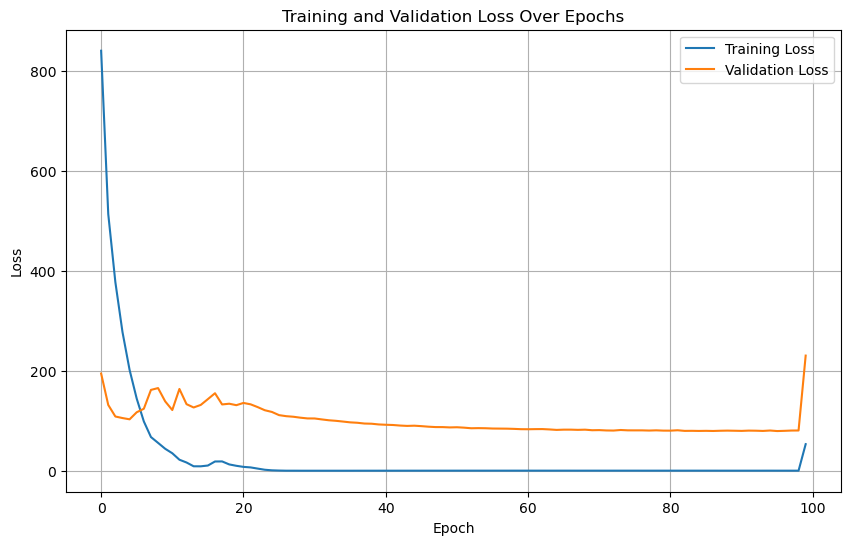

In [145]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


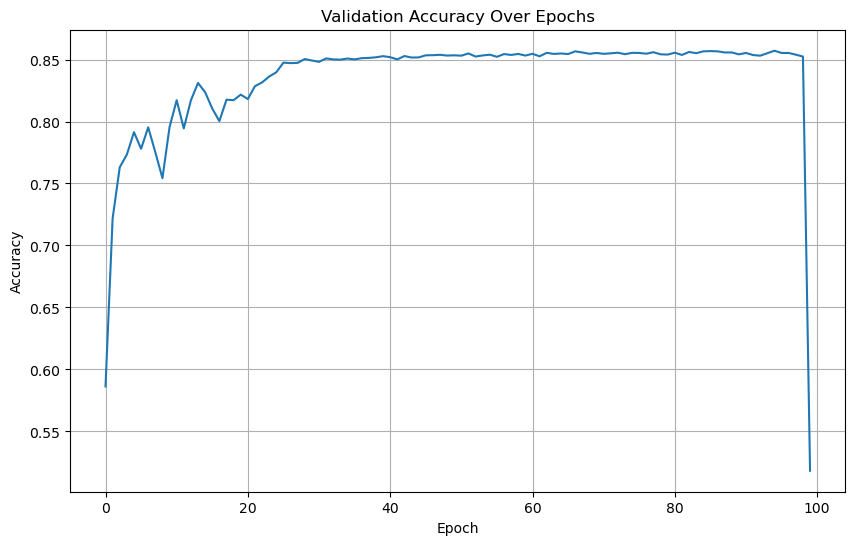

In [147]:
plt.figure(figsize=(10,6))
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.show()

Results on Test Set

In [ ]:

model = ResNet18()
state_dict = torch.load(file_name)

# Remove the 'module.' prefix from the keys
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove the 'module.' prefix
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [162]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:  # Replace `test_loader` with your DataLoader for evaluation
        inputs, labels = inputs.to(device), labels.long().to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 85.38%


In [ ]:

cm = confusion_matrix(all_labels, all_preds)


class_accuracies = cm.diagonal() / cm.sum(axis=1)

class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[i] * 100:.2f}%")


Accuracy for class 'plane': 86.70%
Accuracy for class 'car': 93.80%
Accuracy for class 'bird': 77.50%
Accuracy for class 'cat': 72.70%
Accuracy for class 'deer': 84.70%
Accuracy for class 'dog': 75.60%
Accuracy for class 'frog': 89.20%
Accuracy for class 'horse': 88.00%
Accuracy for class 'ship': 93.40%
Accuracy for class 'truck': 92.20%


Resnet-18 Hyper parameters fine tuning

#### batch_size=128, epochs = 200

In [48]:
batch_size = 128
train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(validation_images, validation_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=batch_size, shuffle=False)
device = 'cuda'
cudnn.benchmark = True

model = ResNet18()
model = model.to(device)
model = torch.nn.DataParallel(model)

learning_rate = 0.01
file_name = 'resnet18_cifar10.pth'

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.0002)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Identity()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

In [ ]:
train_loss, val_loss, val_acc = training(200, model, criterion, optimizer, device,train_loader, file_name)

AlexNet from Scratch

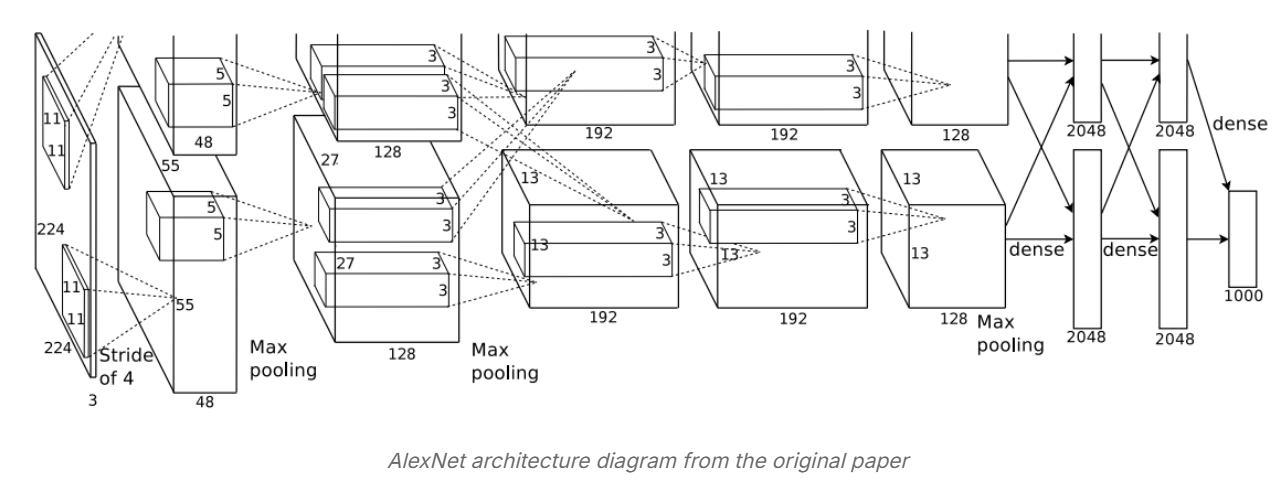

In [179]:
# class AlexNet(nn.Module):
#     def __init__(self, channels=3, fc1_in_features=9216, num_classes=10):
#         super().__init__()
#         self.model = nn.Sequential(
#             #conv1
#             nn.Conv2d(in_channels=channels, out_channels=96, kernel_size=(11,11), stride=4, padding=0),
#             nn.ReLU(),
#             nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
#             nn.MaxPool2d(kernel_size=3, stride=2),

#             #conv2
#             nn.Conv2d(in_channels=96, out_channels=256,kernel_size=(5,5), padding=2),
#             nn.ReLU(),
#             nn.LocalResponseNorm(size=5, alpha=1e-4,beta=0.75,k=2),
#             nn.MaxPool2d(kernel_size=(3,3),stride=2),

#             #conv3
#             nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3,3)),
#             nn.ReLU(),

#             #conv4
#             nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3,3)),
#             nn.ReLU(),

#             #conv5
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(3,3), stride=2),

#             #fc1
#             nn.Linear(in_features=fc1_in_features, out_features=4096),
#             nn.Dropout(0.5),
#             nn.ReLU(),

#             #fc2
#             nn.Linear(in_features=4096, out_features=4096),
#             nn.Dropout(0.5),
#             nn.ReLU(),

#             #fc3
#             nn.Linear(in_features=4096, out_features=num_classes),
#             nn.LogSoftmax(dim=1),


#         )
    
#     def forward(self, x):
#         out = self.model(x)
#         return out
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super().__init__()
        
        self.model = nn.Sequential(
            # Conv1
            nn.Conv2d(in_channels=channels, out_channels=96, kernel_size=(5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),

            # Conv2
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),

            # Conv3
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), padding=1),
            nn.ReLU(),

            # Conv4
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),

            # Conv5
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        )
        
        # Calculate the size after the last convolution layer
        self.fc1_in_features = 256 * 3 * 3  # Adjusted for output after pooling
        self.fc1 = nn.Linear(in_features=self.fc1_in_features, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=num_classes)

    def forward(self, x):
        out = self.model(x)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layers
        out = F.relu(self.fc1(out))
        out = F.dropout(out, p=0.5, training=self.training)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.fc3(out)
        return F.log_softmax(out, dim=1)


In [180]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

model = AlexNet()

model = torch.nn.DataParallel(model)

learning_rate = 0.01
file_name = 'alexnet_cifar10.pth'

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.0002)

In [181]:

model.to(device)

DataParallel(
  (module): AlexNet(
    (model): Sequential(
      (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc1): Linear(in_features=2304, out_features=4096, bias=True)
    (fc2): Linear(in_features=4096, out_features=4096, bias=True)
    (fc3): Linear(in_features=4096, out_featu

In [182]:
train_loss, val_loss, val_acc = training(100, model, criterion, optimizer, device,train_loader, file_name)

Epoch [1/100], Train Loss: 2.2179, Validation Loss: 1.9626, Validation Accuracy: 22.87%
Epoch [2/100], Train Loss: 1.7648, Validation Loss: 1.5935, Validation Accuracy: 41.21%
Epoch [3/100], Train Loss: 1.4554, Validation Loss: 1.2940, Validation Accuracy: 51.87%
Epoch [4/100], Train Loss: 1.2211, Validation Loss: 1.0564, Validation Accuracy: 61.28%
Epoch [5/100], Train Loss: 1.0416, Validation Loss: 1.0476, Validation Accuracy: 63.32%
Epoch [6/100], Train Loss: 0.8995, Validation Loss: 0.8889, Validation Accuracy: 69.77%
Epoch [7/100], Train Loss: 0.7877, Validation Loss: 0.7833, Validation Accuracy: 72.78%
Epoch [8/100], Train Loss: 0.6884, Validation Loss: 0.7643, Validation Accuracy: 74.13%
Epoch [9/100], Train Loss: 0.6035, Validation Loss: 0.7636, Validation Accuracy: 74.59%
Epoch [10/100], Train Loss: 0.5136, Validation Loss: 0.7075, Validation Accuracy: 76.74%
Epoch [11/100], Train Loss: 0.4438, Validation Loss: 0.7557, Validation Accuracy: 76.50%
Epoch [12/100], Train Loss: 0.

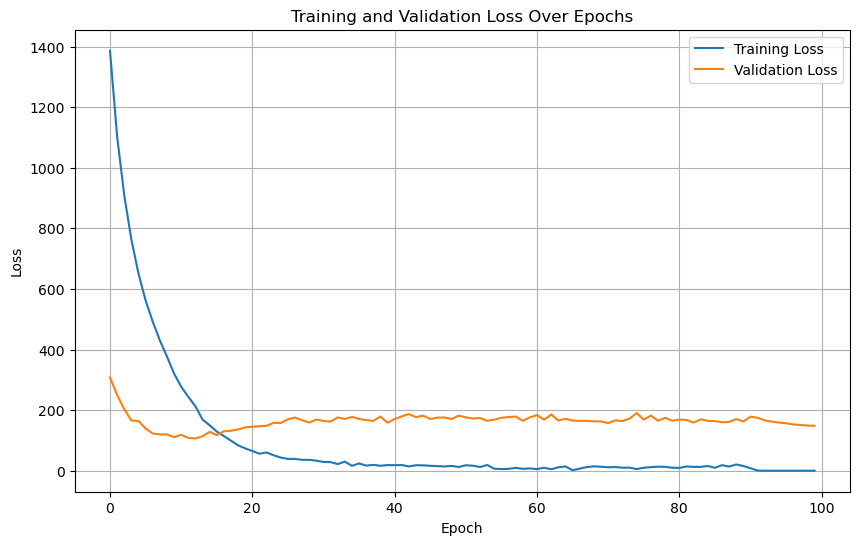

In [188]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


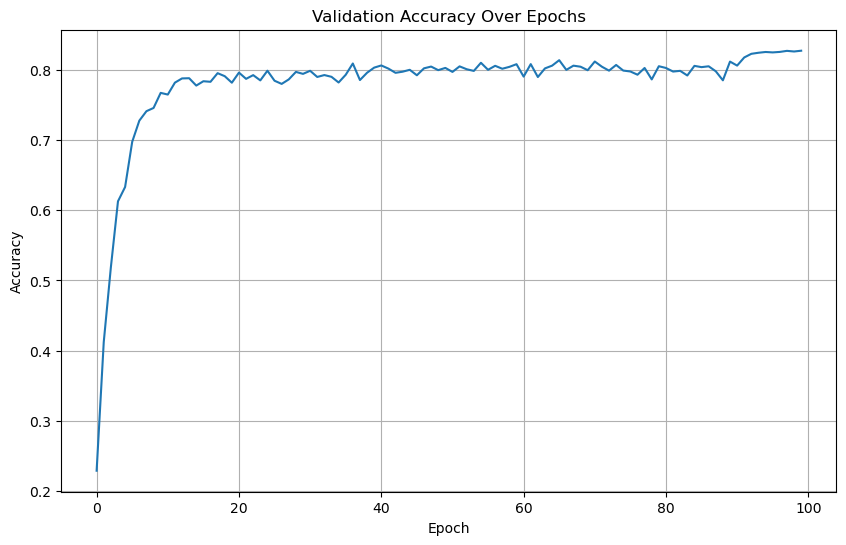

In [189]:
plt.figure(figsize=(10,6))
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.show()

Test AlexNet

In [184]:

model = AlexNet()
state_dict = torch.load(file_name)

# Remove the 'module.' prefix from the keys
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove the 'module.' prefix
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [186]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
all_preds = []
all_labels = []
model.to(device)

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:  # Replace `test_loader` with your DataLoader for evaluation
        inputs, labels = inputs.to(device), labels.long().to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 77.35%


In [187]:

cm = confusion_matrix(all_labels, all_preds)


class_accuracies = cm.diagonal() / cm.sum(axis=1)

class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[i] * 100:.2f}%")


Accuracy for class 'plane': 81.40%
Accuracy for class 'car': 89.30%
Accuracy for class 'bird': 58.70%
Accuracy for class 'cat': 60.70%
Accuracy for class 'deer': 76.90%
Accuracy for class 'dog': 67.50%
Accuracy for class 'frog': 87.50%
Accuracy for class 'horse': 85.00%
Accuracy for class 'ship': 81.10%
Accuracy for class 'truck': 85.40%


VGG-16 from Scratch

In [5]:
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,10)
        )
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                # Apply Kaiming Normal initialization for Conv layers
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    init.constant_(layer.bias, 0)
            elif isinstance(layer, nn.Linear):
                # Apply Xavier Normal initialization for Fully Connected layers
                init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    init.constant_(layer.bias, 0)
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #         m.bias.data.zero_()
    
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

#====================================
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))


In [27]:
(train_images, train_labels), (validation_images, validation_labels), (test_images, test_labels) = load_cifar10_data(data_dir)

train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2) 
train_labels = torch.tensor(train_labels, dtype=torch.float32)
validation_images = torch.tensor(validation_images, dtype=torch.float32).permute(0, 3, 1, 2)  
validation_labels = torch.tensor(validation_labels, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)  
test_labels = torch.tensor(test_labels, dtype=torch.float32)


tranform_train = transforms.Compose([transforms.ToPILImage(),
                                    #  transforms.Resize((224,224)), 
                                     transforms.RandomHorizontalFlip(p=0.7), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                          std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.ToPILImage(),
                                    # transforms.Resize((224,224)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])])


train_set = CIFAR10CustomDataset(train_images, train_labels, tranform_train)
test_set = CIFAR10CustomDataset(test_images, test_labels, tranform_test)
validation_set = CIFAR10CustomDataset(validation_images, validation_labels, tranform_test)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(TensorDataset(validation_images, validation_labels), batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=batch_size, shuffle=False)



In [15]:
model = vgg16()
model.features = torch.nn.DataParallel(model.features)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cudnn.benchmark = True
file_name = "vgg16_cifar10.pth"
criterion = nn.CrossEntropyLoss()
learning_rate=0.01
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.0002)
# optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001) 
train_loss, val_loss, val_acc = training(100, model, criterion, optimizer, device,train_loader, file_name)




C:\Users\ASUS\AppData\Local\Temp\ipykernel_17440\1709088659.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17440\1709088659.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


Epoch [1/100], Train Loss: 2.0082, Validation Loss: 1.7670, Validation Accuracy: 29.04%
Epoch [2/100], Train Loss: 1.5983, Validation Loss: 1.3847, Validation Accuracy: 47.98%
Epoch [3/100], Train Loss: 1.2703, Validation Loss: 1.1142, Validation Accuracy: 59.86%
Epoch [4/100], Train Loss: 1.0324, Validation Loss: 0.9032, Validation Accuracy: 68.45%
Epoch [5/100], Train Loss: 0.8752, Validation Loss: 0.8997, Validation Accuracy: 69.44%
Epoch [6/100], Train Loss: 0.7662, Validation Loss: 0.7239, Validation Accuracy: 75.18%
Epoch [7/100], Train Loss: 0.6771, Validation Loss: 0.7654, Validation Accuracy: 74.13%
Epoch [8/100], Train Loss: 0.5933, Validation Loss: 0.6482, Validation Accuracy: 78.02%
Epoch [9/100], Train Loss: 0.5330, Validation Loss: 0.6434, Validation Accuracy: 79.01%
Epoch [10/100], Train Loss: 0.4762, Validation Loss: 0.6417, Validation Accuracy: 79.94%
Epoch [11/100], Train Loss: 0.4236, Validation Loss: 0.6341, Validation Accuracy: 79.85%
Epoch [12/100], Train Loss: 0.

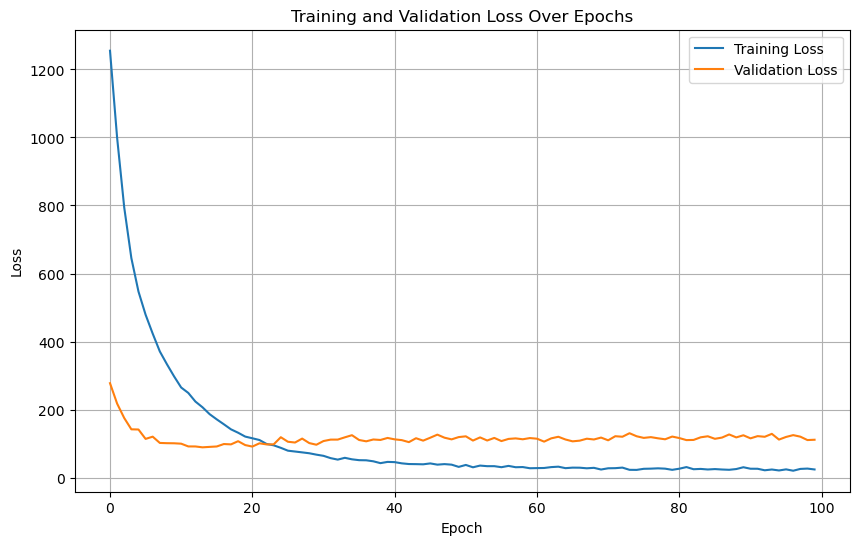

In [21]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


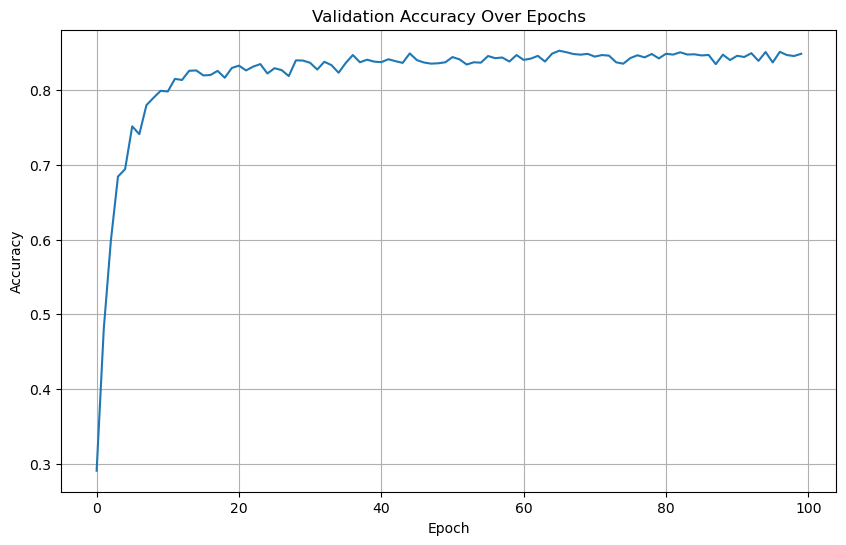

In [22]:
plt.figure(figsize=(10,6))
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.show()

In [25]:

model = vgg16()
file_name ='vgg16_cifar10.pth'
state_dict = torch.load(file_name)

# Remove the 'module.' prefix from the keys
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove the 'module.' prefix
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [28]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
all_preds = []
all_labels = []
model.to(device)

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:  # Replace `test_loader` with your DataLoader for evaluation
        inputs, labels = inputs.to(device), labels.long().to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17440\1709088659.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17440\1709088659.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


Test Accuracy: 81.91%


In [29]:

cm = confusion_matrix(all_labels, all_preds)


class_accuracies = cm.diagonal() / cm.sum(axis=1)

class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[i] * 100:.2f}%")


Accuracy for class 'plane': 82.80%
Accuracy for class 'car': 93.90%
Accuracy for class 'bird': 74.80%
Accuracy for class 'cat': 69.60%
Accuracy for class 'deer': 82.00%
Accuracy for class 'dog': 73.60%
Accuracy for class 'frog': 88.40%
Accuracy for class 'horse': 83.30%
Accuracy for class 'ship': 81.40%
Accuracy for class 'truck': 89.30%
